In [1]:
import numpy as np
import pandas as pd
import fiona
import geopandas as gpd
import os
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt

In [2]:
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

In [183]:
# Add frequency count to the dataframe
dataDir = r"C:\Users\DUANYUEYUN\Documents\GRID3\Health facilities\Data\SLE\Cleaned Data"
filename = "combined_list_0814.csv"
df = pd.read_csv(dataDir + '\\' + filename)

New columns introduced:

- `match_name`: best match short name
- `sub_count`: number of subclusters 
- `match_score`: match score, nan means the short name for that row is matched to itself
- `sub_seq`: sub feature sequence within the cluster

In [184]:
def find_subclusters(df, fac_name='Facility_Name', short_name='Short_Name',
                     cluster='FEAT_SEQ', simple_score=80,
                    simple_score_min=50, partial_score=80, partial_score2=90):
    """
    fac_name: column name for facility name
    short_name: column name for cleaned short facility name
    cluster: feature sequence based on spatial proximity
    """

    # strip whitespaces to remove empty strings like ' '
    df[fac_name]=df[fac_name].str.strip()
    df[short_name]=df[short_name].str.strip()
    # replace empty string with NA
    df[fac_name].replace('',np.nan,inplace=True)
    df[short_name].replace('',np.nan,inplace=True)
    
    # if the cleaned short name is NA, just use original facility name instead
    names = []
    for idx, row in df.iterrows():
        if isinstance(row[short_name], str):
            names.append(row[short_name])
        else:
            names.append(row[fac_name])
    df[short_name] = names 
    
    # drop NA in short name
    df.dropna(subset=[short_name], inplace=True)

    counts = df.groupby(cluster).size()
    counts = pd.DataFrame({'freq_count':counts})
    counts.reset_index(inplace=True)

    # join back to the original dataframe
    df = df.merge(counts, on =[cluster])

    # sort values based on feature sequence and short name
    df.sort_values(by=[cluster, short_name], inplace=True)
    # group by feature sequence
    df_grouped = df.groupby(cluster)

    # store the matched name
    match_names = []
    # store count of subclusters
    sub_counts = []
    # store score of matching
    match_scores = []
    # store types of matching
    match_types = []

    for group_name, df_group in df_grouped:
        # obtain list of names
        names = df_group[short_name].to_list()
        ###index = len(names)//2
        
        # use the first name as the potential candidates for finding a match
        # maybe use the median name or a randomly selected name to start with is better
        match_candidates = [names[0]]
        match_names.append(names[0])
        match_scores.append(np.nan)
        match_types.append('Self')

        for i in range(1, len(names)):

            name = names[i]

            # use match candidates to find best match and compute match score
            match_name1, score1 = process.extractOne(name, match_candidates, scorer = fuzz.ratio)
            match_name2, score2 = process.extractOne(name, match_candidates, scorer = fuzz.partial_ratio)

            # score based on simple ratio
            # or for very short strings, a single letter difference will result in low score
            # consider two short strings as a match if there's only 1 letter difference
            if score1>=simple_score or (1-score1/100) * len(name) <= 1:
                # append match name and score
                match_names.append(match_name1)
                match_scores.append(score1)
                match_types.append('Simple match')

            # if simple ratio not that high, check partial ratio
            elif score1>=simple_score_min and score2>=partial_score:
                # append match name and score
                match_names.append(match_name2)
                match_scores.append(score2)
                match_types.append('Partial match')

            elif score1>=simple_score_min:
                # check scores again after sorting the letters in names individually
                match_candidates2 = [''.join(sorted(candidate)) for candidate in match_candidates]
                match_name3, score3 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.ratio)
                match_name4, score4 = process.extractOne(''.join(sorted(name)), match_candidates2, 
                                                         scorer = fuzz.partial_ratio)

                # or for very short strings, a single letter difference will result in low score
                # consider two short strings as a match if there's only 1 letter difference
                if score3>=simple_score or (1-score3/100) * len(name) <= 1:
                    # append match name and score
                    index = match_candidates2.index(match_name3)
                    match_names.append(match_candidates[index])
                    match_scores.append(score3)
                    match_types.append('Sorted simple match')

                # if simple ratio not that high, check partial ratio
                elif score3>=simple_score_min and score4>=partial_score2:
                    # append match name and score
                    index = match_candidates2.index(match_name4)
                    match_names.append(match_candidates[index])
                    match_scores.append(score4)
                    match_types.append('Sorted partial match')

                # if nothing above works, add the name to match candidates
                else:
                    match_candidates.append(name)
                    match_names.append(name)
                    match_scores.append(np.nan)
                    match_types.append('Self')

            # the match score based on simple ratio is lower than the minimum required
            # just match the name to itself and add it to match candidates
            else:
                match_candidates.append(name)
                match_names.append(name)
                match_scores.append(np.nan)
                match_types.append('Self')

        for i in range(len(names)):
            sub_counts.append(len(match_candidates))
    
    df['match_name'] = match_names
    df['sub_count'] = sub_counts
    df['match_score'] = match_scores
    df['match_type'] = match_types
    
    def rank(s):
        return s.rank(method='dense')
    
    # assign a sub sequence number
    df['sub_seq'] = df.groupby('FEAT_SEQ')['match_name'].apply(rank)
    
    df.sort_values(by=['FEAT_SEQ', 'sub_seq', 'Source'], inplace=True)
    
    return df

In [185]:
def show_results(df, sub_count=3, 
                 cols=['District', 'Chiefdom', 'Facility_Name', 
                       'Facility_Type', 'FEAT_SEQ', 'Source', 'Short_Name',
                       'match_name', 'sub_count', 'match_score', 'sub_seq',
                      'match_type'], 
                 sample_size = 3,
                 operation='>='):
    
    """Function to display the results:
    sub_count: number of subclusters, criterion to filter clusters;
    sample_size: number of clusters to show;
    operation: can either be >= or ==."""
    
    if operation=='>=':
        res = df[df['sub_count']>=sub_count]
        seqs = res['FEAT_SEQ'].unique()
        seqs = pd.Series(seqs).sample(sample_size)
        res = res[res['FEAT_SEQ'].isin(seqs)]
    if operation=='==':
        res = df[df['sub_count']==sub_count]
        seqs = res['FEAT_SEQ'].unique()
        seqs = pd.Series(seqs).sample(sample_size)
        res = res[res['FEAT_SEQ'].isin(seqs)]
    return res[cols]

In [186]:
def show_cluster(df, feat_seq, 
                 cols=['District', 'Chiefdom', 'Facility_Name', 
                       'Facility_Type', 'FEAT_SEQ', 'Source', 'Short_Name',
                       'match_name', 'sub_count', 'match_score', 'sub_seq',
                      'match_type']):
    
    """Function to display the results for a certain cluster"""
    
    return df[df['FEAT_SEQ']==feat_seq][cols]

In [187]:
df_processed = find_subclusters(df, cluster='FEAT_SEQ')

In [146]:
#df_processed.to_csv(dataDir + '\\processed_list_v2_0821.csv')

In [188]:
# show number of clusters by the count of subclusters
df_processed.groupby('sub_count').agg(count=('FEAT_SEQ', 'nunique'))

,count
sub_count,
1,1390
2,133
3,21
4,3
5,5
6,2
9,1
38,1


In [189]:
# showing 1 randomly sampled cluster with exactly 6 subclusters
res = show_results(df_processed, sub_count=3, operation='==', sample_size=3)
# res

In [190]:
# showing results for cluster 1
res=show_cluster(df_processed, feat_seq=1)
#res

In [215]:
def cal_cluster_ratio(df, cluster='FEAT_SEQ',
                     subcluster = 'sub_seq', match_name='match_name',
                     fac_type = 'Facility_Type', freq='freq_count',
                     source = 'Source'):
    """
    Calculate cluster ratio after fuzzy match.
    
    cluster: feature sequence based on spatial proximity.
    subcluster: sub cluster sequence after fuzzy match on short facility name.
    match_name: column name for matched name.
    fac_type: column name for facility type.
    freq: column name for frequency count of the cluster
    """
    
    def source_counts(s):
        return list(s.value_counts(sort=False).values)
    def sources(s):
        return list(s.unique())
    
    df['Source'] = df['Source'].astype('category')
    res = df.groupby([cluster, subcluster])\
    .agg(n_subcluster=(source,'count'), n_cluster=(freq, 'max'),
        match_name=(match_name,'first'), facility_type=(fac_type,'first'),
        num_source = (source, 'nunique'), sources = (source, sources),
        source_details = (source, source_counts))
    res['cluster_ratio'] = res['n_subcluster']/res['n_cluster']
    res.reset_index(inplace=True)
    res['clusterID'] = pd.Series(res[cluster]*1000+res[subcluster]).astype('int')
    
    res2 = pd.DataFrame(res['source_details'].to_list(), 
                    columns=df[source].cat.categories.to_list())
    res = pd.concat([res, res2], axis=1)
    res.drop(columns=['source_details'], inplace=True)
    
    return res

In [216]:
res = cal_cluster_ratio(df_processed)
res.head()

,FEAT_SEQ,sub_seq,n_subcluster,n_cluster,match_name,facility_type,num_source,sources,cluster_ratio,clusterID,Consolidated Facility List,ISS,SARA
0,1,1.0,3,3,Baiwala,CHC,3,"[Consolidated Facility List, ISS, SARA]",1.0,1001,1,1,1
1,2,1.0,3,3,Nagbena,CHP,3,"[Consolidated Facility List, ISS, SARA]",1.0,2001,1,1,1
2,3,1.0,2,2,Sienga,MCHP,2,"[Consolidated Facility List, SARA]",1.0,3001,1,0,1
3,4,1.0,4,4,Daru,CHC,3,"[Consolidated Facility List, ISS, SARA]",1.0,4001,1,2,1
4,5,1.0,3,3,Kambama,CHP,3,"[Consolidated Facility List, ISS, SARA]",1.0,5001,1,1,1


Text(0.5, 1.0, 'Histogram of cluster ratio')

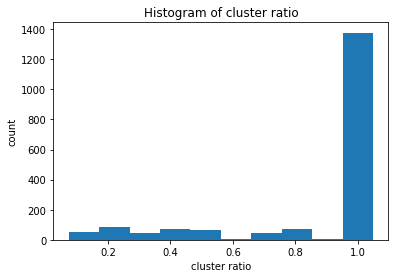

In [156]:
f = plt.hist(res['cluster_ratio'], bins=10, align='right')
plt.xlabel('cluster ratio')
plt.ylabel('count')
plt.title('Histogram of cluster ratio')

In [218]:
res.to_csv(dataDir+'\\SLE_match_results_0826.csv' , index=False)